In [1]:
import pandas as pd
import json
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the experiments directory path
experiments_dir = Path("/data/projects/punim0478/setiawand/Computer-Vision-COMP90086/outputs/experiments")

def load_experiment_data(exp_dir):
    """Load config and metrics data from an experiment directory."""
    config_path = exp_dir / "config.json"
    metrics_path = exp_dir / "best_metrics.json"
    
    # Initialize result dictionary
    result = {"experiment_name": exp_dir.name}
    
    # Load config data
    if config_path.exists():
        with open(config_path, 'r') as f:
            config = json.load(f)
            
        # Extract requested config fields
        config_fields = [
            "encoder", "fusion", "regression_head", "segmentation_head", 
            "dropout", "fusion_channels", "batch_size", "num_epochs", 
            "lr", "weight_decay", "calorie_weight", "seg_weight", 
            "use_segmentation", "use_augment"
        ]
        
        for field in config_fields:
            result[field] = config.get(field, None)
    
    # Load metrics data
    if metrics_path.exists():
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
            
        # Extract metrics fields
        metrics_fields = ["mae", "mse", "mape"]
        for field in metrics_fields:
            result[field] = metrics.get(field, None)
            
        # Also add epoch info
        result["best_epoch"] = metrics.get("epoch", None)
    
    return result

# Scan all experiment directories
experiment_data = []
for exp_dir in experiments_dir.iterdir():
    if exp_dir.is_dir():
        try:
            data = load_experiment_data(exp_dir)
            experiment_data.append(data)
            print(f"Loaded: {exp_dir.name}")
        except Exception as e:
            print(f"Error loading {exp_dir.name}: {e}")

print(f"\nTotal experiments loaded: {len(experiment_data)}")

# Create DataFrame and sort by 'mse' (ascending: best first)
df = pd.DataFrame(experiment_data)
df = df.sort_values('mse', ascending=True).reset_index(drop=True)

# Display basic info about the dataset
print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Display first few rows (lowest mse first)
df.head()


Loaded: exp13_inception_lr_1.1e4_fine_tune
Loaded: exp11_resnet18_inception_minimal_head
Loaded: exp16_inception_fusion_channels_768
Loaded: exp11_resnet18_inception_se_head
Loaded: exp9_inception_resnet34_no_seg
Loaded: exp13_inception_wd_2e6_optimal
Loaded: exp14_ensemble_lr_variation
Loaded: exp0_baseline_r18_no_seg_no_aug
Loaded: exp1_early_fusion_r18_no_aug_seg_weight_0.4
Loaded: exp2_fpn_seg_r18_seg_weight_0.5
Loaded: exp5_gated_r18_seg_weight_0.5
Loaded: exp0_baseline_r18_seg_aug
Loaded: exp12_resnet18_inception_dropout_0.5
Loaded: exp15_inception_linear_scheduler
Loaded: exp5_gated_r18_seg_weight_0.3
Loaded: exp10_early_fusion_light_head
Loaded: exp14_ensemble_dropout_variation_0.2
Loaded: exp8_inception_lr_1.2e-4_tuning
Loaded: exp8_inception_lr_8e-5_tuning
Loaded: exp11_resnet18_inception_light_head
Loaded: exp14_ensemble_dropout_variation_0.3
Loaded: exp11_resnet18_inception_deep_head
Loaded: exp12_resnet18_inception_onecycle
Loaded: exp0_baseline_r34_no_seg_no_aug
Loaded: e

,experiment_name,encoder,fusion,regression_head,segmentation_head,dropout,fusion_channels,batch_size,num_epochs,lr,weight_decay,calorie_weight,seg_weight,use_segmentation,use_augment,mae,mse,mape,best_epoch
0,exp14_ensemble_lr_variation,resnet18,inception,standard,standard,0.4,512,32,40,0.000095,0.000001,1.0,0.5,False,False,33.369640,2368.149902,4.034998e+09,16.0
1,exp14_ensemble_dropout_variation_0.3,resnet18,inception,standard,standard,0.3,512,32,50,0.000030,0.000001,1.0,0.5,False,False,61.150528,7849.625488,5.606363e+09,21.0
2,exp14_ensemble_dropout_variation_0.2,resnet18,inception,standard,standard,0.2,512,32,50,0.000030,0.000001,1.0,0.5,False,False,61.552433,8097.936035,2.217623e+10,23.0
3,exp14_ensemble_dropout_variation_0.3_weight_de...,resnet18,inception,standard,standard,0.4,512,32,50,0.000030,0.000010,1.0,0.5,False,False,59.278187,8144.110840,7.353914e+09,35.0
4,exp14_ensemble_seed_123,resnet18,inception,standard,standard,0.4,512,32,40,0.000100,0.000001,1.0,0.5,False,False,60.654079,8277.505859,1.933789e+10,25.0


In [2]:
# Data cleaning and preprocessing
print("=== DATA OVERVIEW ===")
print(f"Total experiments: {len(df)}")
print(f"Experiments with metrics: {df['mae'].notna().sum()}")
print(f"Experiments missing metrics: {df['mae'].isna().sum()}")

# Show experiments missing metrics
missing_metrics = df[df['mae'].isna()]['experiment_name'].tolist()
if missing_metrics:
    print(f"\nExperiments missing best_metrics.json:")
    for exp in missing_metrics:
        print(f"  - {exp}")

# Remove experiments without metrics for analysis
df_clean = df.dropna(subset=['mae', 'mse', 'mape']).copy()
print(f"\nAnalyzing {len(df_clean)} experiments with complete data")

# Display summary statistics for metrics
print("\n=== METRICS SUMMARY ===")
metrics_cols = ['mae', 'mse', 'mape', 'best_epoch']
print(df_clean[metrics_cols].describe())

# Show unique values for categorical variables
print("\n=== CONFIGURATION SUMMARY ===")
categorical_cols = ['encoder', 'fusion', 'regression_head', 'segmentation_head', 'use_segmentation', 'use_augment']
for col in categorical_cols:
    unique_vals = df_clean[col].unique()
    print(f"{col}: {unique_vals}")

# Display the complete dataframe
print("\n=== COMPLETE EXPERIMENT DATA ===")
# Sort by MSE (best performance first)
df_display = df_clean.sort_values('mse').reset_index(drop=True)
df_display.to_csv("analysis.csv")


=== DATA OVERVIEW ===
Total experiments: 65
Experiments with metrics: 62
Experiments missing metrics: 3

Experiments missing best_metrics.json:
  - exp0_baseline_r34_no_seg_no_aug
  - exp0_baseline_r34_no_seg
  - exp3_early_fpn_r18_seg_weight_0.4

Analyzing 62 experiments with complete data

=== METRICS SUMMARY ===
              mae            mse          mape  best_epoch
count   62.000000      62.000000  6.200000e+01   62.000000
mean    70.701691   11763.600712  1.147617e+10   22.129032
std     25.680813   13275.922969  7.354282e+09    9.047206
min     33.369640    2368.149902  2.513144e+08    1.000000
25%     63.720189    8930.694336  5.928183e+09   16.000000
50%     65.815002    9335.343750  9.958310e+09   20.000000
75%     69.224237    9884.606934  1.648154e+10   29.000000
max    236.318436  105230.109375  3.428576e+10   39.000000

=== CONFIGURATION SUMMARY ===
encoder: ['resnet18' 'early_fusion_resnet18' 'resnet34']
fusion: ['inception' 'middle' 'cross_modal_attention' 'late_weig

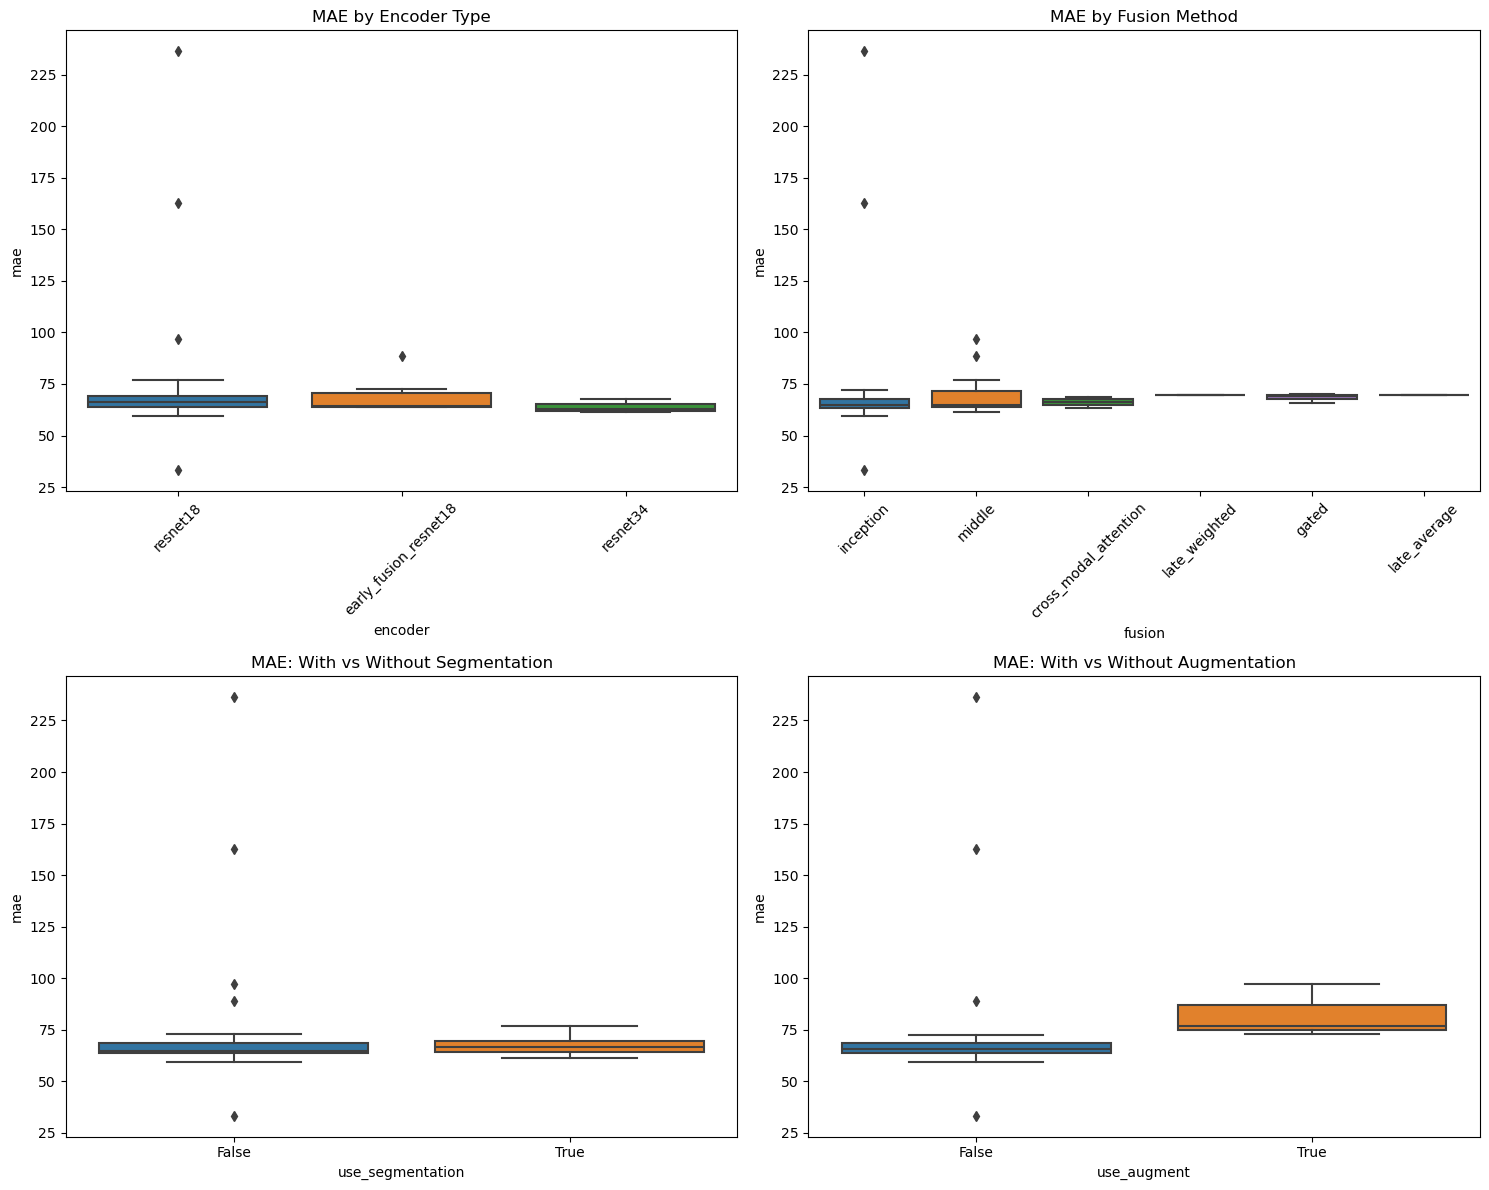

=== CORRELATION ANALYSIS ===


/apps/easybuild-2022/easybuild/software/Core/Anaconda3/2024.02-1/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


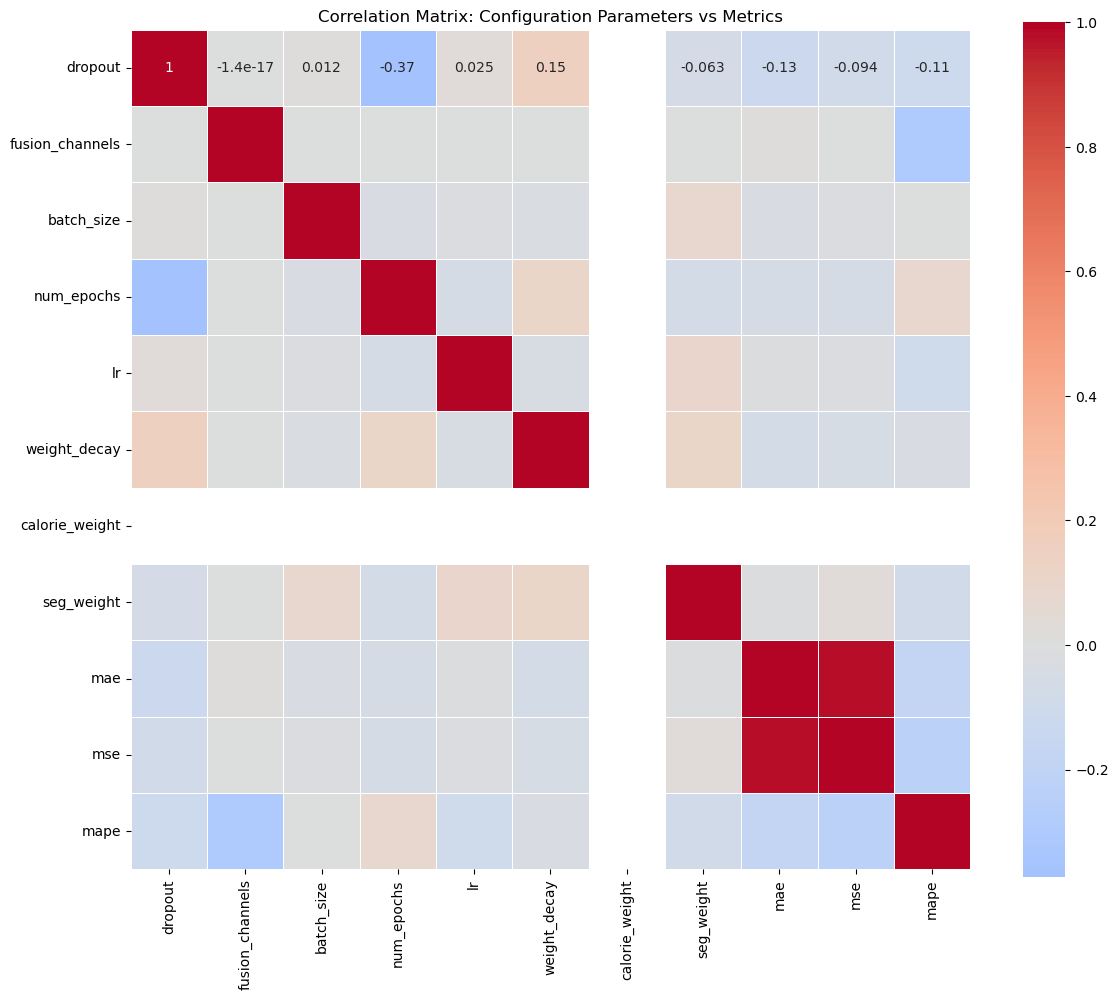

In [3]:
# Performance Analysis and Visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. MAE comparison across different encoders
sns.boxplot(data=df_clean, x='encoder', y='mae', ax=axes[0,0])
axes[0,0].set_title('MAE by Encoder Type')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. MAE comparison across fusion methods
sns.boxplot(data=df_clean, x='fusion', y='mae', ax=axes[0,1])
axes[0,1].set_title('MAE by Fusion Method')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Impact of segmentation
sns.boxplot(data=df_clean, x='use_segmentation', y='mae', ax=axes[1,0])
axes[1,0].set_title('MAE: With vs Without Segmentation')

# 4. Impact of augmentation
sns.boxplot(data=df_clean, x='use_augment', y='mae', ax=axes[1,1])
axes[1,1].set_title('MAE: With vs Without Augmentation')

plt.tight_layout()
plt.show()

# Correlation analysis
print("=== CORRELATION ANALYSIS ===")
# Select numeric columns for correlation
numeric_cols = ['dropout', 'fusion_channels', 'batch_size', 'num_epochs', 'lr', 
                'weight_decay', 'calorie_weight', 'seg_weight', 'mae', 'mse', 'mape']
correlation_data = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Configuration Parameters vs Metrics')
plt.tight_layout()
plt.show()


In [4]:
# Detailed Analysis and Best Performing Models
print("=== TOP 10 BEST PERFORMING MODELS (by MAE) ===")
top_10 = df_clean.nsmallest(10, 'mae')[['experiment_name', 'encoder', 'fusion', 'use_segmentation', 
                                        'use_augment', 'seg_weight', 'mae', 'mse', 'mape']]
print(top_10.to_string(index=False))

print("\n=== ANALYSIS BY EXPERIMENT TYPE ===")

# Group by main experiment categories
def categorize_experiment(name):
    if 'baseline' in name:
        return 'Baseline'
    elif 'early_fusion' in name:
        return 'Early Fusion'
    elif 'fpn_seg' in name:
        return 'FPN Segmentation'
    elif 'early_fpn' in name:
        return 'Early FPN'
    elif 'cross_attn' in name:
        return 'Cross Attention'
    elif 'gated' in name:
        return 'Gated Fusion'
    else:
        return 'Other'

df_clean['experiment_category'] = df_clean['experiment_name'].apply(categorize_experiment)

# Performance by category
category_stats = df_clean.groupby('experiment_category')[['mae', 'mse', 'mape']].agg(['mean', 'std', 'min', 'max'])
print(category_stats)

# Best model in each category
print("\n=== BEST MODEL IN EACH CATEGORY ===")
best_per_category = df_clean.loc[df_clean.groupby('experiment_category')['mae'].idxmin()]
best_summary = best_per_category[['experiment_category', 'experiment_name', 'encoder', 'fusion', 
                                  'use_segmentation', 'seg_weight', 'mae', 'mse', 'mape']]
print(best_summary.to_string(index=False))

# Impact analysis
print("\n=== IMPACT ANALYSIS ===")
print("Average MAE by configuration:")
print(f"With Segmentation: {df_clean[df_clean['use_segmentation']==True]['mae'].mean():.2f}")
print(f"Without Segmentation: {df_clean[df_clean['use_segmentation']==False]['mae'].mean():.2f}")
print(f"With Augmentation: {df_clean[df_clean['use_augment']==True]['mae'].mean():.2f}")
print(f"Without Augmentation: {df_clean[df_clean['use_augment']==False]['mae'].mean():.2f}")

# Segmentation weight analysis
seg_experiments = df_clean[df_clean['use_segmentation']==True]
if len(seg_experiments) > 0:
    print(f"\nSegmentation Weight Analysis (for experiments using segmentation):")
    seg_weight_analysis = seg_experiments.groupby('seg_weight')['mae'].agg(['count', 'mean', 'std'])
    print(seg_weight_analysis)

# Save the complete dataframe to CSV for further analysis
output_path = "/data/projects/punim0478/setiawand/Computer-Vision-COMP90086/notebooks/experiment_analysis.csv"
df_clean.to_csv(output_path, index=False)
print(f"\n=== DATA SAVED ===")
print(f"Complete experiment data saved to: {output_path}")
print(f"Columns: {list(df_clean.columns)}")
print(f"Shape: {df_clean.shape}")


=== TOP 10 BEST PERFORMING MODELS (by MAE) ===
                                       experiment_name  encoder    fusion  use_segmentation  use_augment  seg_weight       mae         mse         mape
                           exp14_ensemble_lr_variation resnet18 inception             False        False         0.5 33.369640 2368.149902 4.034998e+09
exp14_ensemble_dropout_variation_0.3_weight_decay_1e-5 resnet18 inception             False        False         0.5 59.278187 8144.110840 7.353914e+09
                               exp14_ensemble_seed_123 resnet18 inception             False        False         0.5 60.654079 8277.505859 1.933789e+10
                  exp14_ensemble_dropout_variation_0.3 resnet18 inception             False        False         0.5 61.150528 7849.625488 5.606363e+09
                  exp9_fpn_seg_resnet34_seg_weight_0.4 resnet34    middle              True        False         0.4 61.444176 9420.232422 5.859383e+09
                         exp8_inception_l